# Modelling and Evaluation

## Objectives

*   Business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Plot distribution of images across train, validation, and test sets.
* Perform image augmentation.
* Map class indices to alter prediction inference for labels.
* Create and train a machine learning model.
* Save the model.
* Plot learning curves to evaluate model performance.
* Evaluate the model using a pickle file.
* Make predictions on a randomly selected image file.

## Additional Comments

* No additional comments here. 

---


# Set The Data Directory & import libraries

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection-in-cherry-leaves'

## Set input directories

Sets the train, test and validation paths

In [5]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

The old version is already available, please create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('The label for the images are:', labels)

The label for the images are: ['healthy', 'powdery_mildew']


## Set image shape

Import saved image shape embedding

In [8]:
import joblib

version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




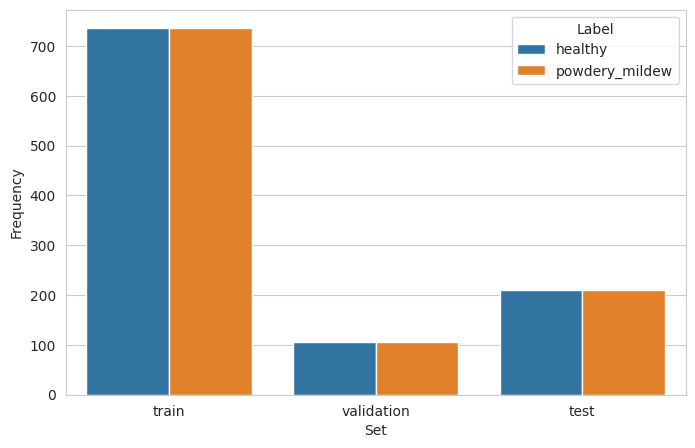

In [9]:
df_img_freq = pd.DataFrame([])

for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(
                data={
                    'Set': folder,
                    'Label': label,
                    'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png', bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

* ### Augment the train image dataset

In [12]:
batch_size = 1 # was set to 1
train_set = augmented_img_data.flow_from_directory(
    train_path, 
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the validation image dataset

In [13]:
validation_img_data = ImageDataGenerator(rescale=1./255)
validation_set = validation_img_data.flow_from_directory(
    valid_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the test image dataset

In [14]:
test_img_data = ImageDataGenerator(rescale=1./255)
test_set = test_img_data.flow_from_directory(                       
    test_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_set.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot the augmented training images

(1, 256, 256, 3)


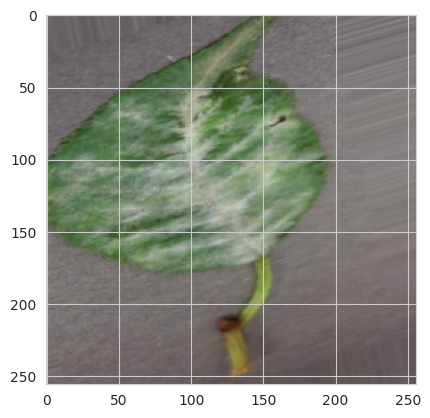

(1, 256, 256, 3)


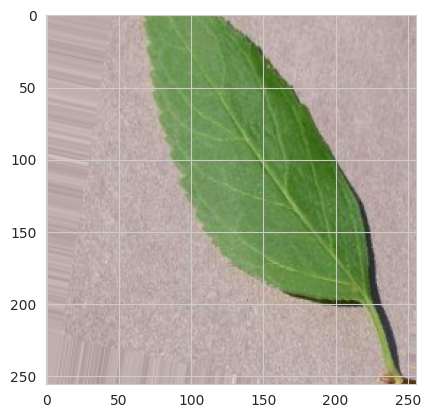

(1, 256, 256, 3)


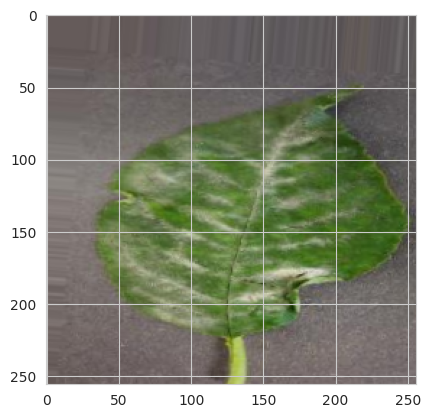

(1, 256, 256, 3)


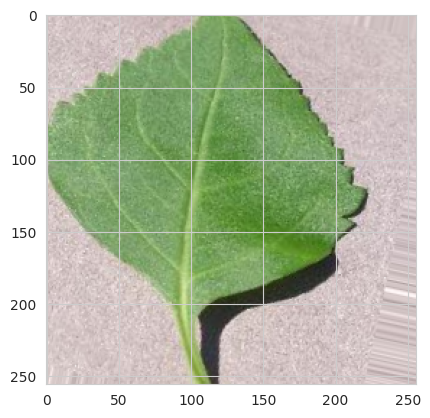

In [15]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot the augmented validation and test images

(1, 256, 256, 3)


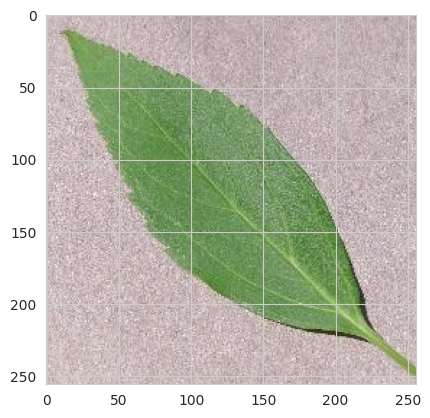

(1, 256, 256, 3)


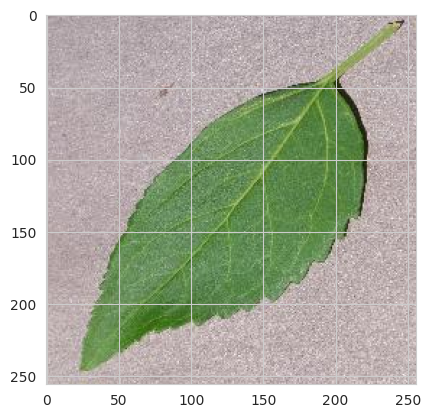

(1, 256, 256, 3)


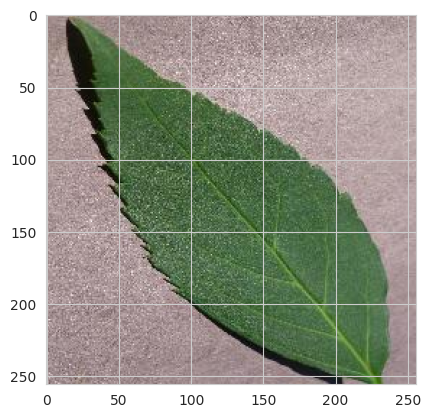

(1, 256, 256, 3)


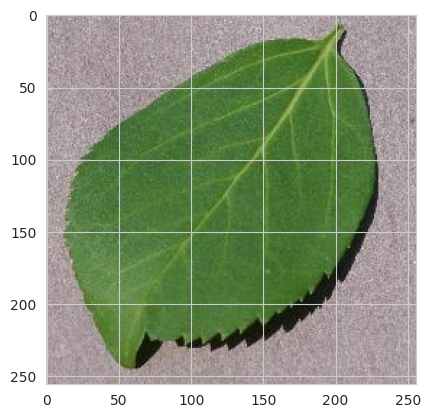

In [16]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(1, 256, 256, 3)


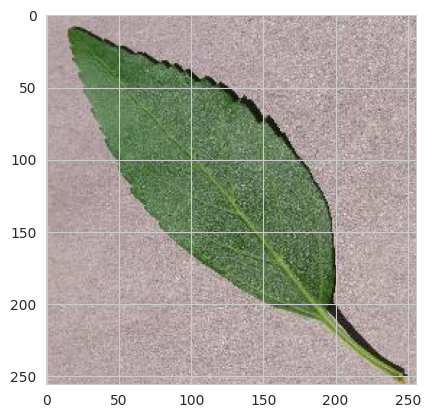

(1, 256, 256, 3)


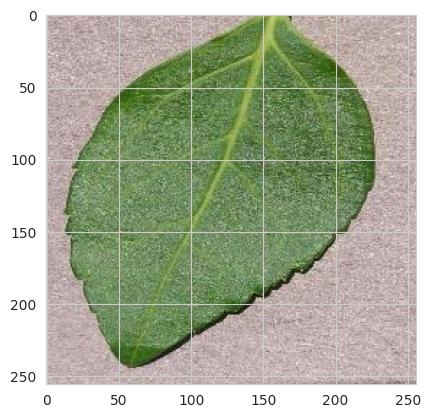

(1, 256, 256, 3)


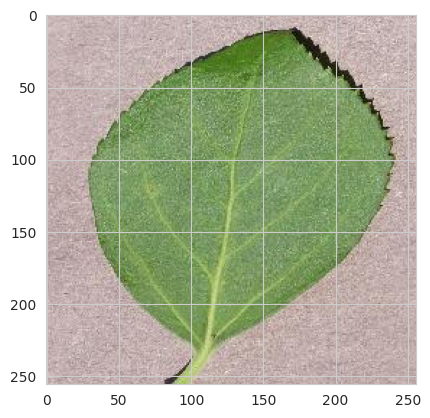

(1, 256, 256, 3)


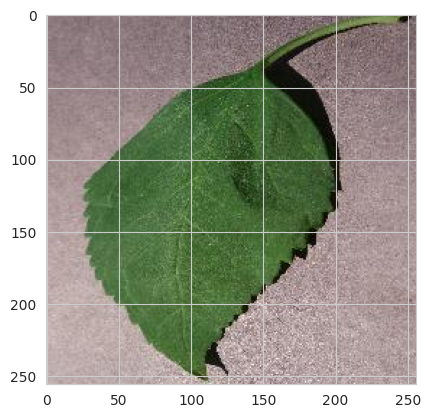

In [17]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Save the class_indices

In [18]:
joblib.dump(
    value=train_set.class_indices,
    filename=f"{file_path}/class_indices.pkl"
)

['outputs/v1/class_indices.pkl']

---

# Model creation

## Machine Learning Model

* ### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

CNN with 5 layers

In [20]:
def generate_tf_model():

    model = Sequential()

    # First convolutional layer 32
    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer 64
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer 128
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional layer 128
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu')) #dense was 128

    # Prevent overfitting
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* ### Generate and Model Summary 

In [21]:
model = generate_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-07-13 16:35:30.752530: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Model Early Stopping 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

train_early_stop = EarlyStopping(monitor='val_loss', patience=4) # tried patients of 4 good outcome


## Fit the model for model training

In [23]:
model = generate_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes),
          validation_data=validation_set,
          callbacks=[train_early_stop],
          verbose=1
          )

2024-07-13 16:35:30.917260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
1472/1472 [==============================] - 121s 82ms/step - loss: 0.6269 - accuracy: 0.7255 - val_loss: 0.5562 - val_accuracy: 0.8095
Epoch 2/25
1472/1472 [==============================] - 118s 80ms/step - loss: 0.4512 - accuracy: 0.8410 - val_loss: 0.2328 - val_accuracy: 0.9286
Epoch 3/25
1472/1472 [==============================] - 118s 80ms/step - loss: 0.2957 - accuracy: 0.9144 - val_loss: 0.0786 - val_accuracy: 0.9810
Epoch 4/25
1472/1472 [==============================] - 119s 81ms/step - loss: 0.1648 - accuracy: 0.9490 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 5/25
1472/1472 [==============================] - 118s 80ms/step - loss: 0.1501 - accuracy: 0.9572 - val_loss: 0.0530 - val_accuracy: 0.9857
Epoch 6/25
1472/1472 [==============================] - 119s 81ms/step - loss: 0.1155 - accuracy: 0.9647 - val_loss: 0.0308 - val_accuracy: 0.9857
Epoch 7/25
1472/1472 [==============================] - 118s 80ms/step - loss: 0.0724 - accuracy: 0.9823 - val_loss: 0